In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import torch
import cv2
import sys
import json
from PIL import Image
from tqdm import tqdm
import multiprocessing as mp
import pydensecrf.utils as utils
import pydensecrf.densecrf as dcrf

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

from src.dataset import *

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
print(f"Pytorch Version:[{torch.__version__}]")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:[{device}]")

Pytorch Version:[1.7.1]
device:[cuda:0]


In [30]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_norm = transforms.Normalize(
    mean = [-m / s for m, s in zip(mean, std)],
    std = [1 / s for s in std]
)

In [31]:
class Cfg:
    batch_size = 4
    saved_dir = "./checkpoints/exp3"
    file_name = "deeplabv3.pt"
    submission_dir = "./submission"
    submission_name = "deeplabv3.csv"

In [32]:
COLORS =[
        [129, 236, 236],
        [2, 132, 227],
        [232, 67, 147],
        [255, 234, 267],
        [0, 184, 148],
        [85, 239, 196],
        [48, 51, 107],
        [255, 159, 26],
        [255, 204, 204],
        [179, 57, 57],
        [248, 243, 212],
    ]

COLORS = np.vstack([[0, 0, 0], COLORS]).astype('uint8')  # (12, 3)으로 쌓아줌

# Normalize 유무 inference 결과

In [59]:
def inference(COLORS, inv_norm, case=0, idx=0):
    """
    Args:
        case : 0 is normalize, resize(256, 256) | 1 is normalize, no resize | 2 is no normalize, resize (256, 256)
    """
    def collate_fn(batch):
        return tuple(zip(*batch))


    test_path = dataset_path + '/test.json'
    
    if case == 0:
        # training setting과 동일한 transform
        test_transform = A.Compose([
                                A.Normalize(),
                                A.Resize(256, 256),
                                ToTensorV2()
                                ])
    elif case == 1:
        test_transform = A.Compose([
                                A.Normalize(),
                                ToTensorV2()
                                ])
    else:
        test_transform = A.Compose([
                        A.Resize(256, 256),
                        ToTensorV2()
                        ])
   

    # test dataset
    test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=Cfg.batch_size,
                                            num_workers=4,
                                            collate_fn=collate_fn)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model = FCN8s(num_classes=12)
    model = smp.DeepLabV3(encoder_name="efficientnet-b0",
            # encoder_depth=5,
            encoder_weights="imagenet",
            in_channels=3,
            classes=12,
            )
    model = model.to(device)

    model_path = os.path.join(Cfg.saved_dir, Cfg.file_name)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)

    print('Start prediction.')
    model.eval()

    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).float().to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()

            break

    print("End prediction.")
#     idx = 0

    if case == 2:
        imgs = imgs[idx]
    else:
        imgs = inv_norm(imgs[idx])
        
    org = np.stack(imgs)
    org = np.transpose(org, (1, 2, 0))
    mask = COLORS[oms[idx]]
    
    if case == 2:
        output = ((0.4 * (org)) + (0.6 * mask)).astype('uint8')
    else:
        output = ((0.4 * (org * 255.)) + (0.6 * mask)).astype('uint8')

    print('Shape of Original Image :', list(imgs.shape))
    print('Shape of Predicted : ', list(oms.shape))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms))])


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    ax1.imshow(org)
    ax1.grid(False)
    ax1.set_title("Original image : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax2.imshow(mask)
    ax2.grid(False)
    ax2.set_title("Predicted : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax3.imshow(output)
    ax3.grid(False)
    ax3.set_title("Mixed Result", fontsize=15)

    plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  0%|          | 0/210 [00:00<?, ?it/s]


End prediction.
Shape of Original Image : [3, 256, 256]
Shape of Predicted :  [4, 256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {9, 'Plastic bag'}]


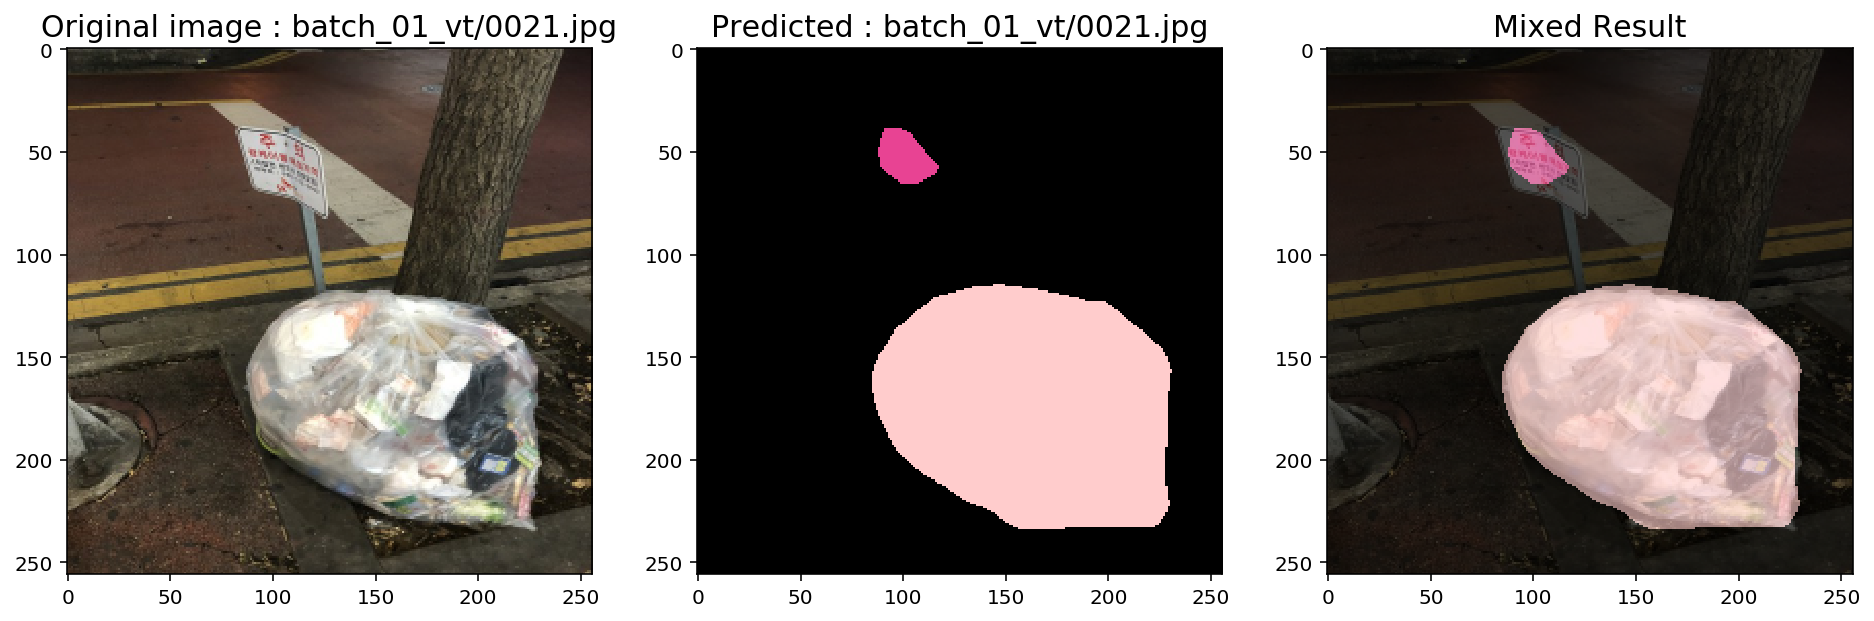

In [42]:
inference(COLORS, inv_norm)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  0%|          | 0/210 [00:00<?, ?it/s]


End prediction.
Shape of Original Image : [3, 512, 512]
Shape of Predicted :  [4, 512, 512]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {'Paper pack', 4}, {'Metal', 5}, {'Glass', 6}, {'Plastic', 7}, {8, 'Styrofoam'}, {9, 'Plastic bag'}, {'Battery', 10}]


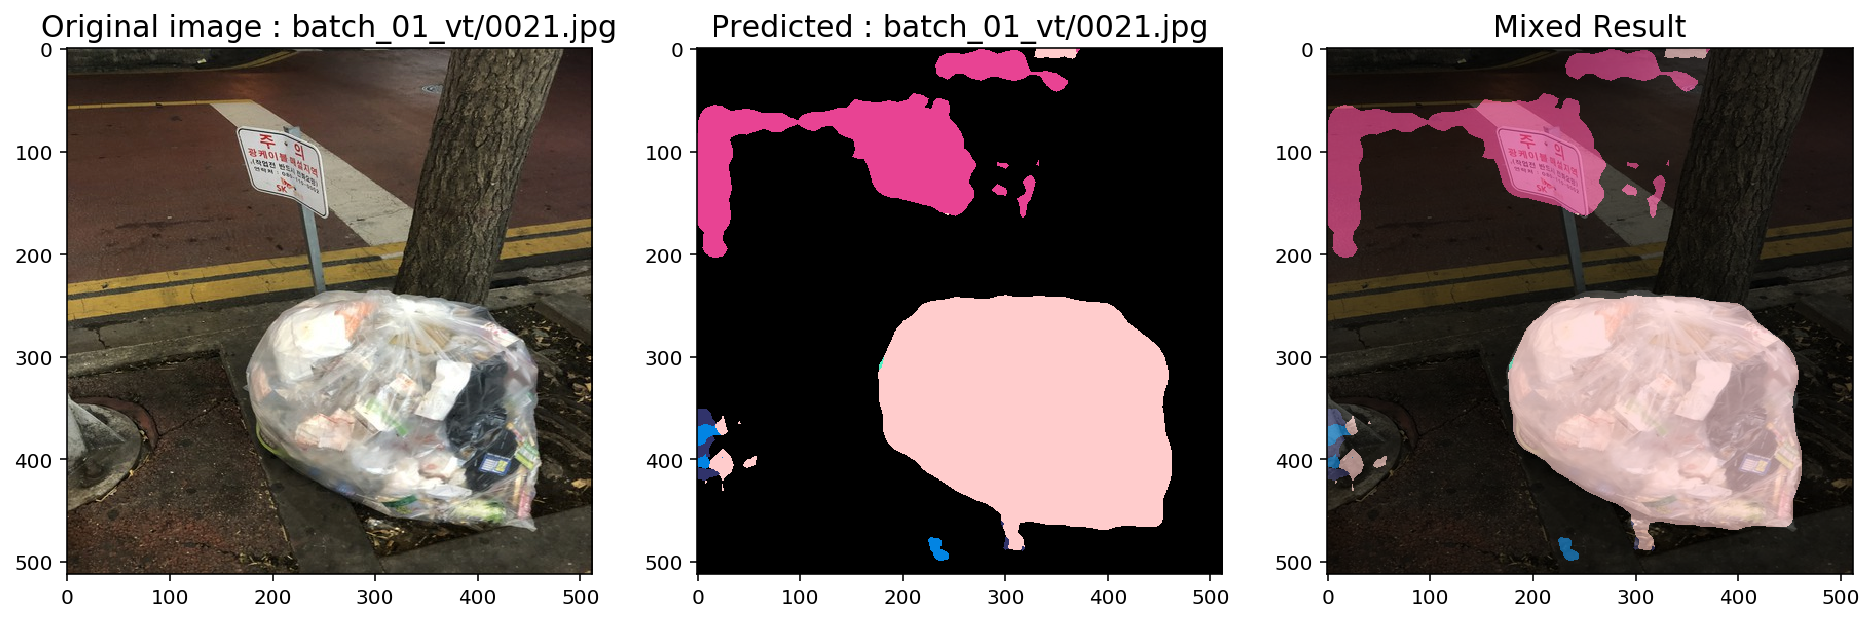

In [43]:
inference(COLORS, inv_norm, case=1)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  0%|          | 0/210 [00:00<?, ?it/s]


End prediction.
Shape of Original Image : [3, 256, 256]
Shape of Predicted :  [4, 256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {1, 'UNKNOWN'}, {'General trash', 2}, {'Paper', 3}, {'Paper pack', 4}, {'Glass', 6}, {'Plastic', 7}, {8, 'Styrofoam'}, {9, 'Plastic bag'}, {'Clothing', 11}]


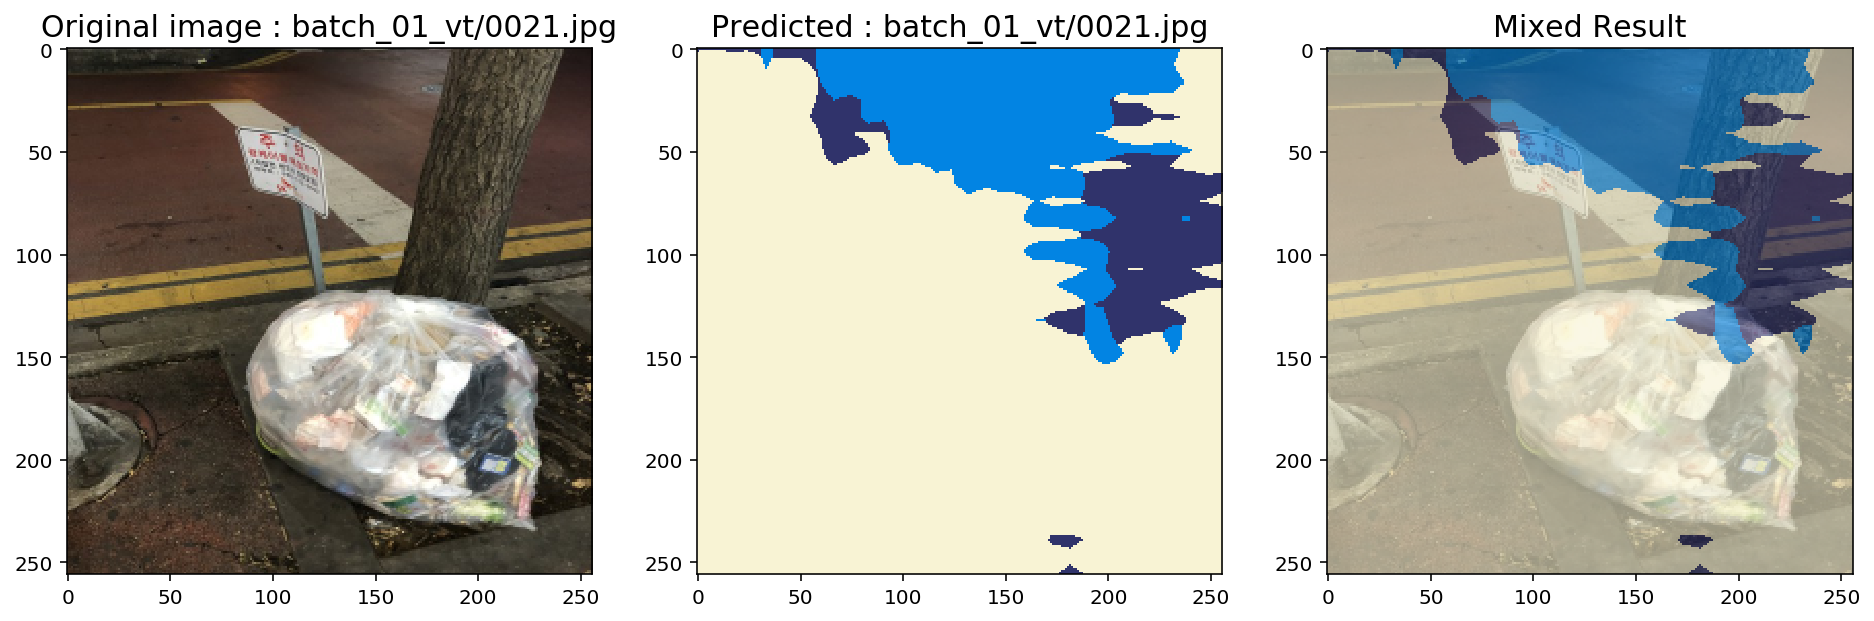

In [44]:
inference(COLORS, inv_norm, case=2)

# DenseCRF inference에 적용

In [54]:
def dense_crf_wrapper(args):
    return dense_crf(args[0], args[1])

def dense_crf(img, output_probs):
    MAX_ITER = 10
    POS_W = 3
    POS_XY_STD = 1
    Bi_W = 4
    Bi_XY_STD = 67
    Bi_RGB_STD = 3

    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q

In [79]:
def inference_crf(is_crf=True):
    def collate_fn(batch):
        return tuple(zip(*batch))


    test_path = dataset_path + '/test.json'

    # training setting과 동일한 transform
    test_transform = A.Compose([
                            A.Normalize(),
                            A.Resize(256, 256),
                            ToTensorV2()
                            ])

    # test dataset
    test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=Cfg.batch_size,
                                            num_workers=4,
                                            collate_fn=collate_fn)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model = FCN8s(num_classes=12)
    model = smp.DeepLabV3(encoder_name="efficientnet-b0",
            # encoder_depth=5,
            encoder_weights="imagenet",
            in_channels=3,
            classes=12,
            )
    model = model.to(device)

    model_path = os.path.join(Cfg.saved_dir, Cfg.file_name)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)

    print('Start prediction.')
    model.eval()

    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):

            outs = model(torch.stack(imgs).float().to(device))
            
            if is_crf:
                probs = F.softmax(outs, dim=1).data.cpu().numpy()

                pool = mp.Pool(mp.cpu_count())
                images = torch.stack(imgs).data.cpu().numpy().astype(np.uint8).transpose(0, 2, 3, 1)
                probs = np.array(pool.map(dense_crf_wrapper, zip(images, probs)))
                pool.close()
                oms = np.argmax(probs, axis=1)
            else:
                oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()

            if step == 2:
                break

    print("End prediction.")
    idx = 1

    imgs = inv_norm(imgs[idx])

    org = np.stack(imgs)
    org = np.transpose(org, (1, 2, 0))
    mask = COLORS[oms[idx]]

    output = ((0.4 * (org * 255.)) + (0.6 * mask)).astype('uint8')

    print('Shape of Original Image :', list(imgs.shape))
    print('Shape of Predicted : ', list(oms.shape))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms))])


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    ax1.imshow(org)
    ax1.grid(False)
    ax1.set_title("Original image : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax2.imshow(mask)
    ax2.grid(False)
    ax2.set_title("Predicted : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax3.imshow(output)
    ax3.grid(False)
    ax3.set_title("Mixed Result", fontsize=15)

    plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  1%|          | 2/210 [00:02<05:02,  1.45s/it]


End prediction.
Shape of Original Image : [3, 256, 256]
Shape of Predicted :  [4, 256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {9, 'Plastic bag'}]


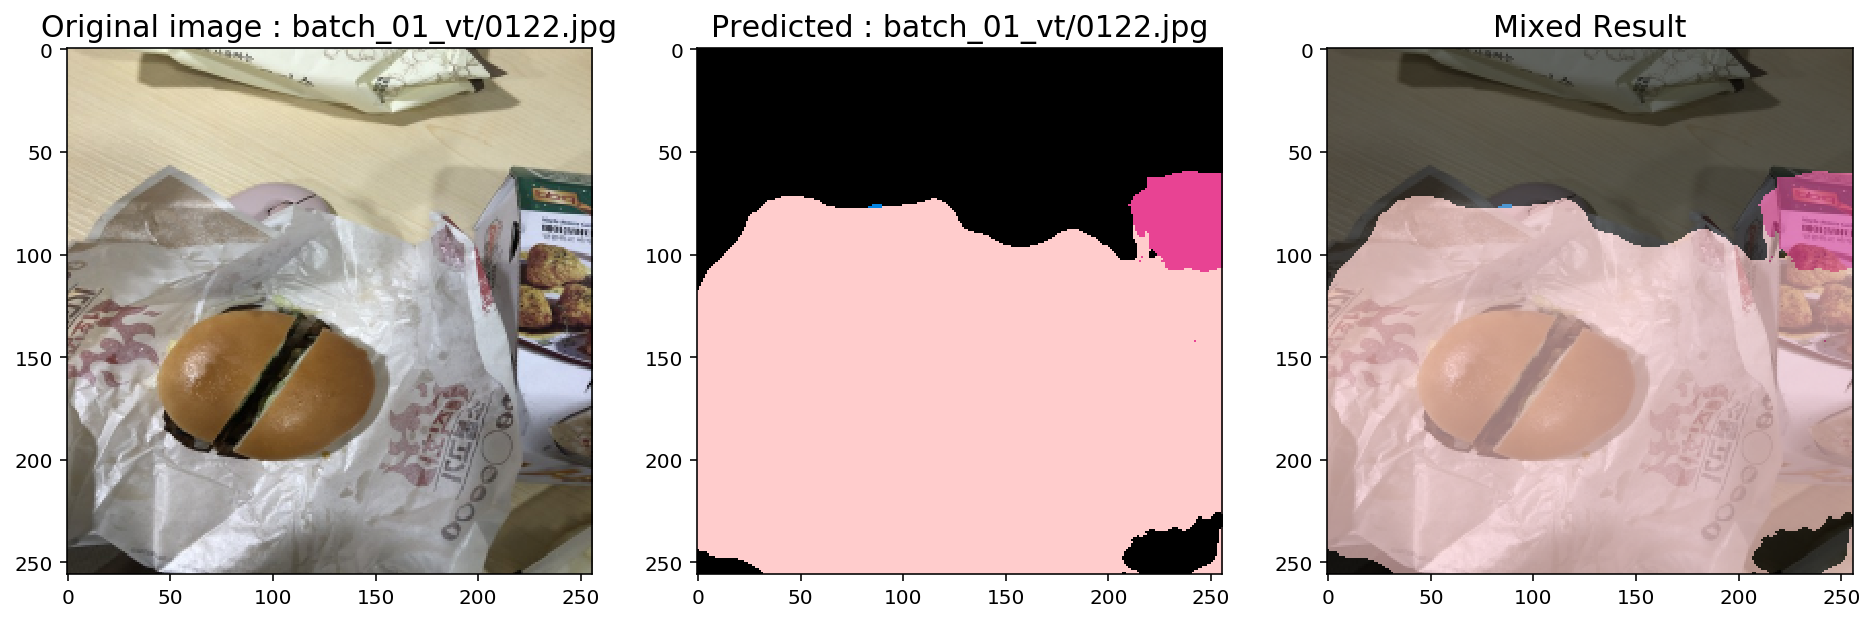

In [80]:
inference_crf()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  1%|          | 2/210 [00:00<01:05,  3.19it/s]


End prediction.
Shape of Original Image : [3, 256, 256]
Shape of Predicted :  [4, 256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {'Metal', 5}, {'Plastic', 7}, {9, 'Plastic bag'}, {'Battery', 10}]


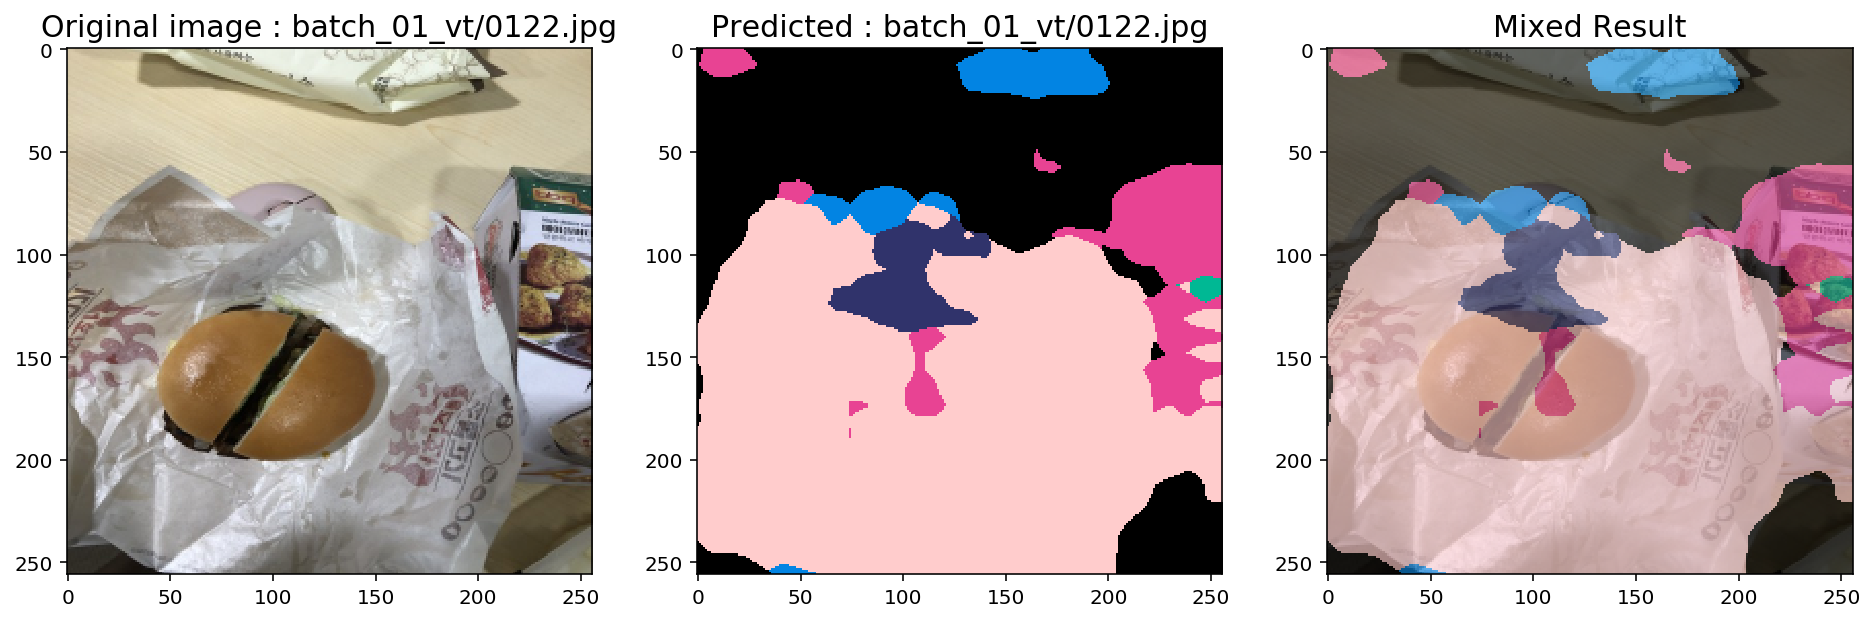

In [81]:
inference_crf(is_crf=False)